# Propensity Score Matching

**Chapter 11, Section 3**

This notebook covers matching on the propensity score instead of full covariates.

## Table of Contents
1. [Intuition](#intuition) - PS matching vs covariate matching
2. [Formal Treatment](#formal) - Caliper and replacement
3. [Numeric Demonstration](#numeric) - Growth mindset application
4. [Implementation](#implementation) - PS matching variants
5. [Interview Appendix](#interview) - Practice questions

---

In [1]:
# Standard imports
import sys
sys.path.insert(0, '../..')

from facure_augment.common import *
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors

# Set notebook style
set_notebook_style()

print("Imports complete")

Imports complete


---

## Intuition

### Why Match on Propensity Score?

**Curse of dimensionality**: Matching on many covariates becomes difficult.

**Solution**: The balancing score theorem tells us we can match on the propensity score instead:

$$e(X) = P(T=1|X) \quad \text{(a single scalar)}$$

Two units with the same PS have balanced covariates on average, even if their individual covariates differ.

### PS Matching vs IPTW

| Aspect | PS Matching | IPTW |
|--------|-------------|------|
| Method | Find similar PS pairs | Reweight all units |
| Sample | Matched subset | Full sample |
| Extreme PS | Discards (if no match) | Up-weights (can be unstable) |
| Efficiency | Lower (discards data) | Higher (uses all data) |

---

In [2]:
# Load data and estimate propensity scores
mindset = load_facure_data("learning_mindset.csv")

covariates = [
    'success_expect', 'ethnicity', 'gender', 'frst_in_family',
    'school_mindset', 'school_achievement', 'school_ethnic_minority',
    'school_poverty', 'school_size'
]

X = mindset[covariates].values
T = mindset['intervention'].values
Y = mindset['achievement_score'].values

# Estimate propensity scores
ps_model = LogisticRegression(C=1e6, max_iter=1000, solver='lbfgs')
ps_model.fit(X, T)
ps = ps_model.predict_proba(X)[:, 1]

mindset['ps'] = ps

print(f"Data: {len(mindset)} students")
print(f"PS range: [{ps.min():.4f}, {ps.max():.4f}]")

Data: 10391 students
PS range: [0.1818, 0.4551]


---

## Formal Treatment

### PS Matching Algorithm

**Input**: Treated units with $e(X_i)$, Control units with $e(X_j)$

**For each treated unit $i$**:
1. Find control unit $j$ with closest $|e(X_i) - e(X_j)|$
2. Form matched pair $(i, j)$

**Variants**:
- **With replacement**: Control can be matched multiple times
- **Without replacement**: Each control used at most once
- **Caliper**: Maximum allowed PS distance for a match

### Caliper Matching

**Definition**: A caliper of width $c$ requires:

$$|e(X_i) - e(X_{j(i)})| \leq c$$

Common choice: $c = 0.2 \times \text{std}(e(X))$

**Purpose**: Avoid poor matches when PS distributions don't overlap.

---

In [3]:
def ps_matching(ps, T, Y, caliper=None, replacement=True):
    """
    Propensity score matching estimator.
    
    Parameters:
    -----------
    ps : propensity scores
    T : treatment indicator
    Y : outcome
    caliper : maximum PS distance for a match (None = no caliper)
    replacement : whether to match with replacement
    """
    # Split by treatment
    treated_idx = np.where(T == 1)[0]
    control_idx = np.where(T == 0)[0]
    
    ps_treated = ps[treated_idx]
    ps_control = ps[control_idx]
    Y_treated = Y[treated_idx]
    Y_control = Y[control_idx]
    
    # Find nearest control for each treated
    matched_effects = []
    unmatched_count = 0
    used_controls = set()
    
    for i, (ps_t, y_t) in enumerate(zip(ps_treated, Y_treated)):
        # Compute distances to all controls
        if replacement:
            distances = np.abs(ps_control - ps_t)
        else:
            # Exclude already-used controls
            available = [j for j in range(len(ps_control)) if j not in used_controls]
            if len(available) == 0:
                unmatched_count += 1
                continue
            distances = np.abs(ps_control[available] - ps_t)
        
        # Find nearest
        if replacement:
            best_idx = np.argmin(distances)
            best_distance = distances[best_idx]
        else:
            best_local_idx = np.argmin(distances)
            best_idx = available[best_local_idx]
            best_distance = distances[best_local_idx]
        
        # Check caliper
        if caliper is not None and best_distance > caliper:
            unmatched_count += 1
            continue
        
        # Record match
        matched_effects.append(y_t - Y_control[best_idx])
        if not replacement:
            used_controls.add(best_idx)
    
    matched_effects = np.array(matched_effects)
    
    return {
        'ATT': matched_effects.mean(),
        'SE': matched_effects.std() / np.sqrt(len(matched_effects)),
        'n_matched': len(matched_effects),
        'n_unmatched': unmatched_count,
        'match_rate': len(matched_effects) / len(treated_idx)
    }

In [4]:
# Compare matching variants
print("PS MATCHING VARIANTS:")
print("=" * 70)

# With replacement, no caliper
result1 = ps_matching(ps, T, Y, caliper=None, replacement=True)
print(f"\nWith replacement, no caliper:")
print(f"  ATT: {result1['ATT']:.4f} (SE: {result1['SE']:.4f})")
print(f"  Match rate: {result1['match_rate']:.1%}")

# Without replacement, no caliper
result2 = ps_matching(ps, T, Y, caliper=None, replacement=False)
print(f"\nWithout replacement, no caliper:")
print(f"  ATT: {result2['ATT']:.4f} (SE: {result2['SE']:.4f})")
print(f"  Match rate: {result2['match_rate']:.1%}")

# With caliper (0.2 * std)
caliper = 0.2 * ps.std()
result3 = ps_matching(ps, T, Y, caliper=caliper, replacement=True)
print(f"\nWith replacement, caliper = {caliper:.4f}:")
print(f"  ATT: {result3['ATT']:.4f} (SE: {result3['SE']:.4f})")
print(f"  Match rate: {result3['match_rate']:.1%}")

PS MATCHING VARIANTS:

With replacement, no caliper:
  ATT: 0.3617 (SE: 0.0196)
  Match rate: 100.0%



Without replacement, no caliper:
  ATT: 0.4021 (SE: 0.0198)
  Match rate: 100.0%

With replacement, caliper = 0.0079:
  ATT: 0.3617 (SE: 0.0196)
  Match rate: 100.0%


---

## Numeric Demonstration

### Match Quality Visualization

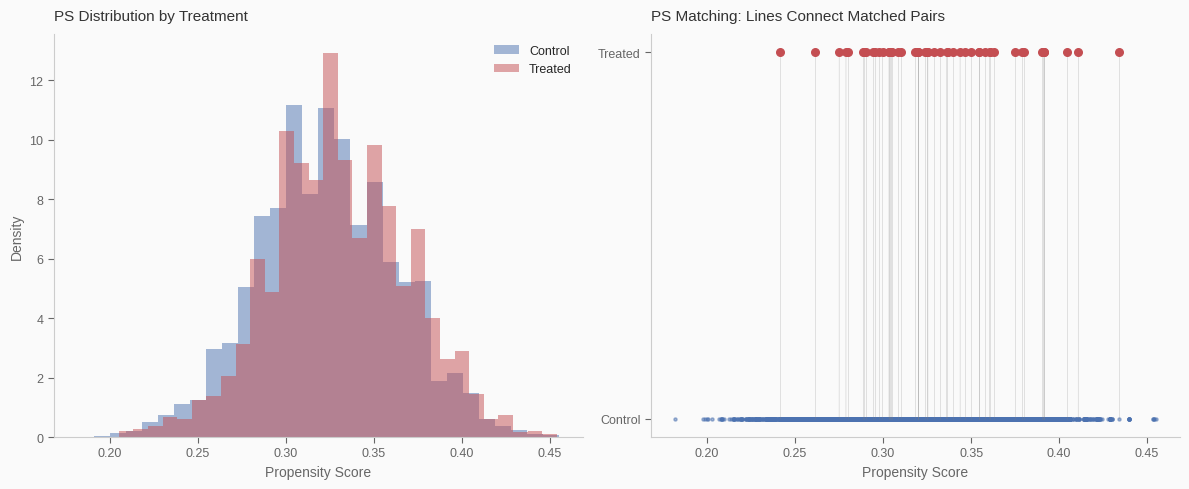

In [5]:
# Visualize PS matching
fig, axes = create_tufte_figure(ncols=2, figsize=(12, 5))

# Left: PS distributions
ax = axes[0]
for t, color, label in [(0, COLORS['blue'], 'Control'), (1, COLORS['red'], 'Treated')]:
    ax.hist(ps[T==t], bins=30, alpha=0.5, color=color, label=label, density=True)

set_tufte_title(ax, "PS Distribution by Treatment")
set_tufte_labels(ax, "Propensity Score", "Density")
ax.legend(frameon=False)

# Right: Show some matches
ax = axes[1]
np.random.seed(42)
sample_treated_idx = np.random.choice(np.where(T==1)[0], 50, replace=False)

# Find matches for these
ps_control = ps[T==0]
control_idx_all = np.where(T==0)[0]

for t_idx in sample_treated_idx:
    ps_t = ps[t_idx]
    # Find nearest control
    distances = np.abs(ps_control - ps_t)
    c_local_idx = np.argmin(distances)
    c_idx = control_idx_all[c_local_idx]
    
    ax.plot([ps_t, ps[c_idx]], [1, 0], color='gray', alpha=0.3, linewidth=0.5)

ax.scatter(ps[sample_treated_idx], np.ones(len(sample_treated_idx)), 
           c=COLORS['red'], s=30, label='Treated', zorder=5)
ax.scatter(ps[control_idx_all], np.zeros(len(control_idx_all)), 
           c=COLORS['blue'], s=5, alpha=0.5, label='Control')

ax.set_yticks([0, 1])
ax.set_yticklabels(['Control', 'Treated'])
set_tufte_title(ax, "PS Matching: Lines Connect Matched Pairs")
set_tufte_labels(ax, "Propensity Score", "")

plt.tight_layout()
plt.show()

In [6]:
# Compare all methods
print("\nCOMPARISON OF ALL METHODS:")
print("=" * 70)

# Naive
naive = Y[T==1].mean() - Y[T==0].mean()
print(f"Naive: {naive:.4f}")

# Regression
formula = 'achievement_score ~ intervention + ' + ' + '.join(covariates)
reg = smf.ols(formula, data=mindset).fit()
print(f"Regression: {reg.params['intervention']:.4f} (SE: {reg.bse['intervention']:.4f})")

# PS matching
print(f"PS Matching (with repl): {result1['ATT']:.4f} (SE: {result1['SE']:.4f})")

# IPTW for comparison
weights = T / ps + (1 - T) / (1 - ps)
mu1 = np.sum(T * Y / ps) / np.sum(T / ps)
mu0 = np.sum((1 - T) * Y / (1 - ps)) / np.sum((1 - T) / (1 - ps))
iptw_ate = mu1 - mu0
print(f"IPTW (Hajek): {iptw_ate:.4f}")


COMPARISON OF ALL METHODS:
Naive: 0.4723
Regression: 0.3986 (SE: 0.0179)
PS Matching (with repl): 0.3617 (SE: 0.0196)
IPTW (Hajek): 0.3946


---

## Implementation

### Tradeoffs Summary

In [7]:
print("PS MATCHING TRADEOFFS:")
print("=" * 70)
print("""
WITH vs WITHOUT REPLACEMENT:
- With: Uses best match for each treated, may reuse controls
- Without: Each control used once, may have worse matches later
- Recommendation: With replacement for ATT, check sensitivity

CALIPER:
- Prevents bad matches (poor overlap regions)
- Common choice: 0.2 * std(PS)
- Tradeoff: Tighter caliper = fewer matches but better quality

PS MATCHING vs IPTW:
- Matching: More transparent, handles extreme PS by discarding
- IPTW: Uses all data, can be unstable with extreme PS
- Recommendation: Try both as robustness check
""")

PS MATCHING TRADEOFFS:

WITH vs WITHOUT REPLACEMENT:
- With: Uses best match for each treated, may reuse controls
- Without: Each control used once, may have worse matches later
- Recommendation: With replacement for ATT, check sensitivity

CALIPER:
- Prevents bad matches (poor overlap regions)
- Common choice: 0.2 * std(PS)
- Tradeoff: Tighter caliper = fewer matches but better quality

PS MATCHING vs IPTW:
- Matching: More transparent, handles extreme PS by discarding
- IPTW: Uses all data, can be unstable with extreme PS
- Recommendation: Try both as robustness check



---

## Interview Appendix

### Practice Questions

**Q1: What are the tradeoffs between PS matching and IPTW?**

<details>
<summary>Solution</summary>

**PS Matching Advantages**:
- Transparent: See exactly which units are compared
- Handles extreme PS naturally (no match found = unit excluded)
- Easy to understand and explain

**PS Matching Disadvantages**:
- Discards unmatched units (loses data)
- Sample size reduced
- Efficiency loss

**IPTW Advantages**:
- Uses all data
- More efficient (lower variance if weights well-behaved)
- Can estimate ATE directly

**IPTW Disadvantages**:
- Extreme weights cause instability
- Less transparent
- May extrapolate to poor overlap regions

**Best practice**: Use both and compare. If results differ, investigate overlap.

</details>

**Q2: What is a caliper in PS matching and how do you choose it?**

<details>
<summary>Solution</summary>

**Definition**: A caliper is a maximum allowed distance for a match:
$$|e(X_i) - e(X_{j(i)})| \leq c$$

**Purpose**: Prevent poor matches in regions with limited overlap.

**Common choices**:
- $c = 0.2 \times \text{std}(e(X))$ (Austin, 2011)
- $c = 0.1$ on PS scale
- $c = 0.25 \times \text{std}(\text{logit}(e(X)))$

**Tradeoff**:
- Tight caliper: Better matches, fewer matches, ATT for well-matched
- Loose caliper: More matches, worse quality, broader ATT

**Practical guidance**:
1. Start without caliper
2. Check match quality
3. Impose caliper if many poor matches
4. Report proportion matched

</details>

**Q3: Should you match with or without replacement?**

<details>
<summary>Solution</summary>

**With replacement**:
- Each treated gets best available control
- Some controls matched multiple times
- Lower bias (always best match)
- Higher variance (effective control sample smaller)

**Without replacement**:
- Each control used at most once
- Later matches may be poor
- Higher bias (constrained matches)
- Lower variance (more unique controls)

**Recommendation**:
- Use **with replacement** for ATT (prioritize bias reduction)
- Check sensitivity to choice
- If results differ, investigate why

**Note**: With replacement requires adjusted SE (accounts for reused controls).

</details>

---

## References

[^1]: Facure, M. (2022). *Causal Inference for the Brave and True*, Chapter 11.

[^2]: Austin, P. C. (2011). Optimal caliper widths for propensity-score matching. *American Journal of Epidemiology*, 173(2), 199-207.

[^3]: Rosenbaum, P. R. (2002). *Observational Studies*. Springer.

[^4]: Cross-reference: PS diagnostics in `11_propensity_score/04_ps_diagnostics.ipynb`